In [1]:
import pandas as pd
import numpy as np
from data_analysis import get_heart_bounds, correlation_coef, graph_3d, graph_cc_distribution, graph_dist_over_axis
from BayesOptLib.bayes_opt.bayesian_optimization import BayesianOptimization
from RandomSampler import RandomSampler
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
matplotlib.use('Qt5Agg')
import seaborn as sns
from bayopt_mesh import get_index, black_box, optimize_point, plot_exploration
from sklearn.metrics.pairwise import euclidean_distances

In [2]:
ecgs = pd.read_csv("simu-data/Heart3_SimuData.csv", header=None).to_numpy()
labels = pd.read_csv("simu-data/Heart3_XYZsub.csv", header=None).to_numpy() / 1000

In [5]:
#see the correlation coefficient matrix
# cor_matrix = np.corrcoef(ecgs)
# cor_matrix = np.abs(cor_matrix)
# cov_matrix =np. diag(np.cov(ecgs))
# cov_matrix.shape
#finding euclidian distance between points 

mat = euclidean_distances(labels,labels)

In [12]:
# check the variability/variance of each location in ECGS


(2000,)

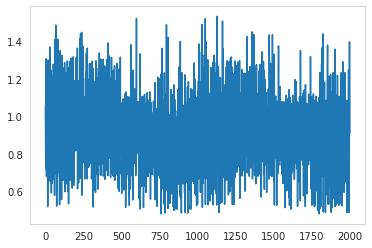

In [13]:
plt.plot(cov_matrix)
plt.show()

In [6]:
labels.shape

(2000, 3)

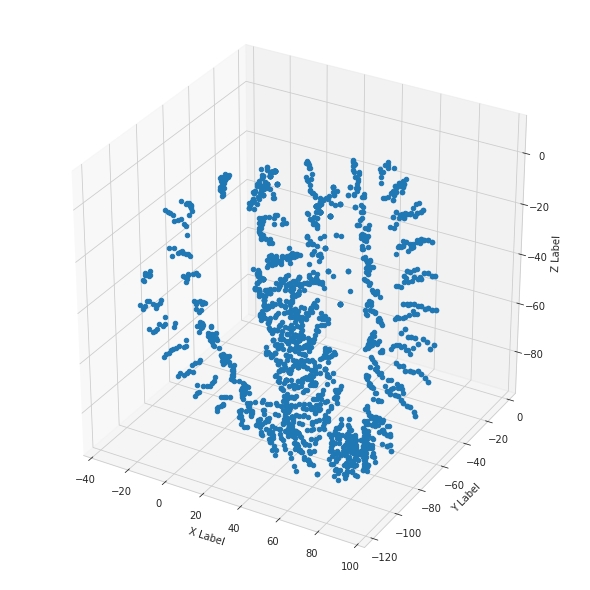

In [4]:
#plot link: https://stackoverflow.com/questions/52285104/3d-scatterplots-in-python-with-hue-colormap-and-legend
sns.set_style("whitegrid", {'axes.grid' : False})
fig = plt.figure(figsize=(8,8)); ax = Axes3D(fig)
x, y, z = labels[:,0], labels[:,1], labels[:,2]

g = ax.scatter(x, y, z, depthshade=False)
ax.set_xlabel('X Label'); ax.set_ylabel('Y Label'); ax.set_zlabel('Z Label')

plt.show()